# Project: Community Detection and Network Resilience

## (a) Construct a network from the dataset. 

In [24]:
import networkx as nx
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from itertools import takewhile
from functools import partial as part
import pickle

c:\Program Files\Python38\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
g = nx.read_gml("../data/netscience.gml")

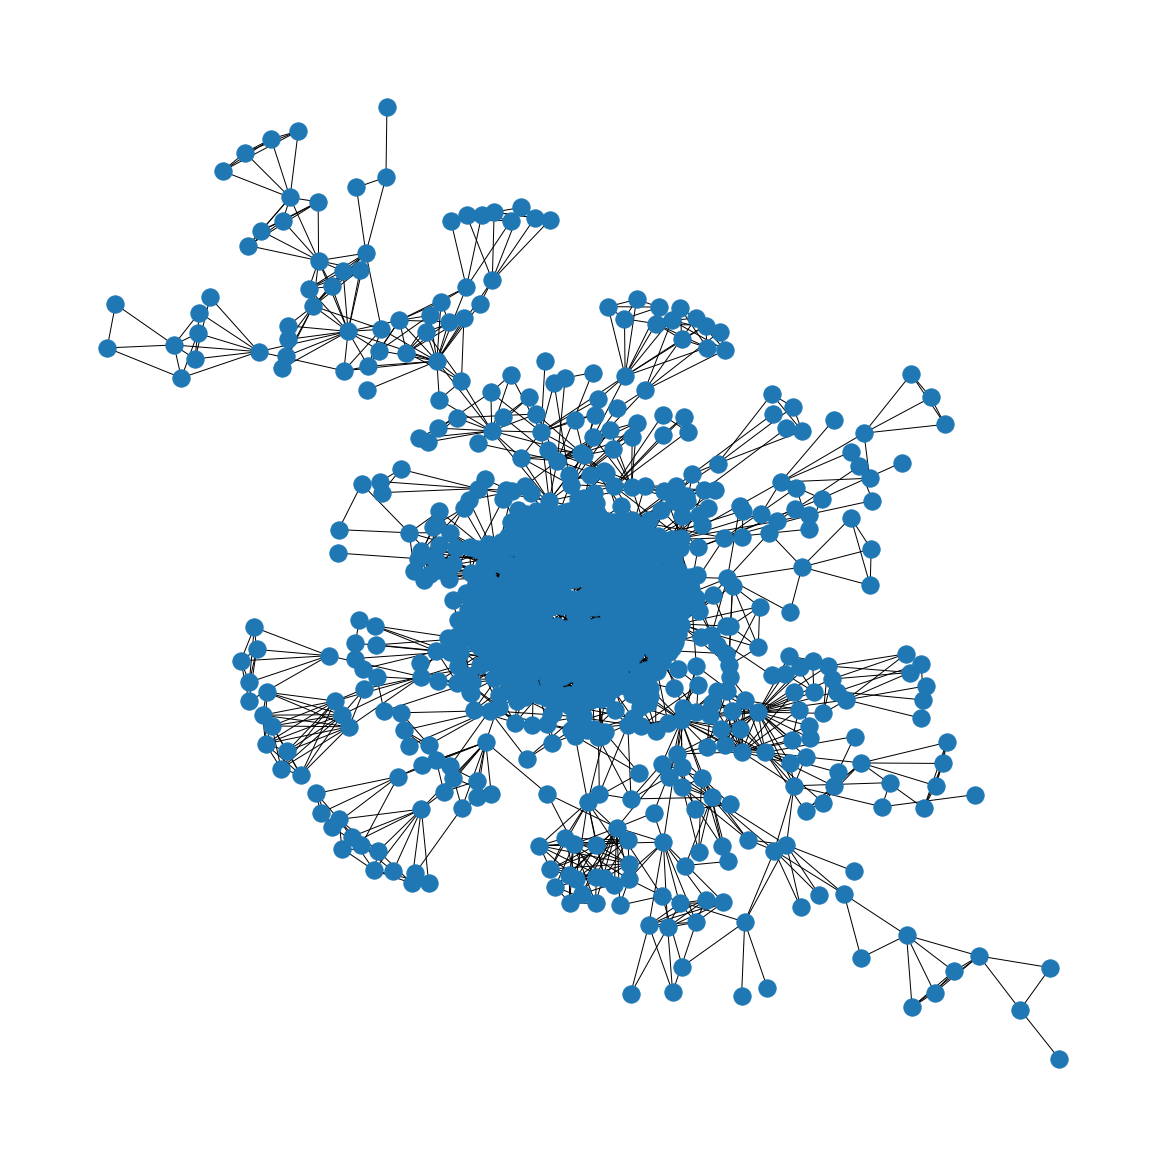

In [3]:
plt.figure(figsize=(16,16))
nx.draw_kamada_kawai(g)
plt.savefig("../fig/network.pdf")
plt.show()

## (b) Plot  its  degree  distribution,  then  compute  its  average  shortest  distance  and average clustering coefficient. 

### Degree distribution

In [39]:
def deg_dist_plot(g: nx.Graph, *args, plotter=plt, fit=False, start_from=None, **kwargs):
    degs = [k for n, k in g.degree if k > 0]
    km, kM = min(degs), max(degs)
    degx = np.arange(km, kM+1)
    disty = (np.bincount(degs)/len(degs))[km:kM+1]
    plotter.scatter(degx, disty, *args, **kwargs,label="degree distribution")
    if fit:
        if start_from is not None:
            disty = disty[degx > start_from]
            degx = degx[degx > start_from]
        degx = degx[disty > 0]
        disty = disty[disty > 0]
        logX = sm.add_constant(np.log10(degx))
        logy = np.log10(disty)

        mod = sm.OLS(logy, logX)
        results = mod.fit()
        a, b = results.params
        fity = degx**b*10**a
        plotter.plot(degx, fity, label="fit", c="orange")


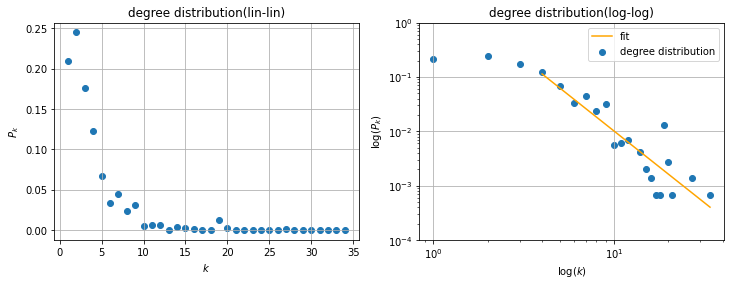

In [40]:
plt.figure(figsize=(12,4))
plt.subplot(121)
deg_dist_plot(g)
plt.xlabel("$k$")
plt.ylabel("$P_k$")
plt.grid(True)
plt.title("degree distribution(lin-lin)")
plt.subplot(122)
deg_dist_plot(g,fit=True,start_from=3)
plt.xlabel("$\log(k)$")
plt.ylabel("$\log(P_k)$")
plt.xscale("log")
plt.yscale("log")
plt.ylim([10**-4,1])
plt.grid(True)
plt.title("degree distribution(log-log)")
plt.legend()
plt.savefig("../fig/deg-dist.pdf")
plt.show()

from this degree distribution, we can see it obeys a power law.

### Average shortest distance

Since this network isn't a connected graph, so we just compute it's average shortest distance for it's giant component.

In [6]:
giant_subgraph = g.subgraph(max(nx.connected_components(g), key=len))

In [22]:
giant_subgraph.number_of_nodes(),np.log(giant_subgraph.number_of_nodes())

(379, 5.937536205082426)

In [7]:
nx.average_shortest_path_length(giant_subgraph)

6.041867347935949

### Average clustering coefficient

In [23]:
nx.average_clustering(giant_subgraph)

0.7412306142925664

## (c) Use the Girvan-Newman algorithm to find its communities. 

In [9]:
maxNComm = 410
gncomm = nx.community.girvan_newman(g)
comm_series = list(takewhile(lambda c: len(c) <= maxNComm, gncomm))

with open("../out/gn-comm-finding.pkl","wb") as output:
    pickle.dump(comm_series,output)

In [10]:
with open("../out/gn-comm-finding.pkl","rb") as inputs:
    comm_series = pickle.load(inputs)

In [11]:
def filter_comm(g: nx.Graph, communities, minsize=30):
    communities = list(filter(lambda c: len(c) >= minsize, communities))
    nodes = set().union(*communities)
    return communities, g.subgraph(nodes)


default_color_map = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan'
]


def community_plot(g: nx.Graph, communities, color_map=default_color_map, minsize=30, **kwargs):
    communities, g = filter_comm(g, communities, minsize)
    node_list = []
    node_color = []
    for i, community in enumerate(communities):
        for node in community:
            node_list.append(node)
            node_color.append(color_map[i])
    nx.draw_kamada_kawai(g, nodelist=node_list,
                         node_color=node_color, **kwargs)
    return communities


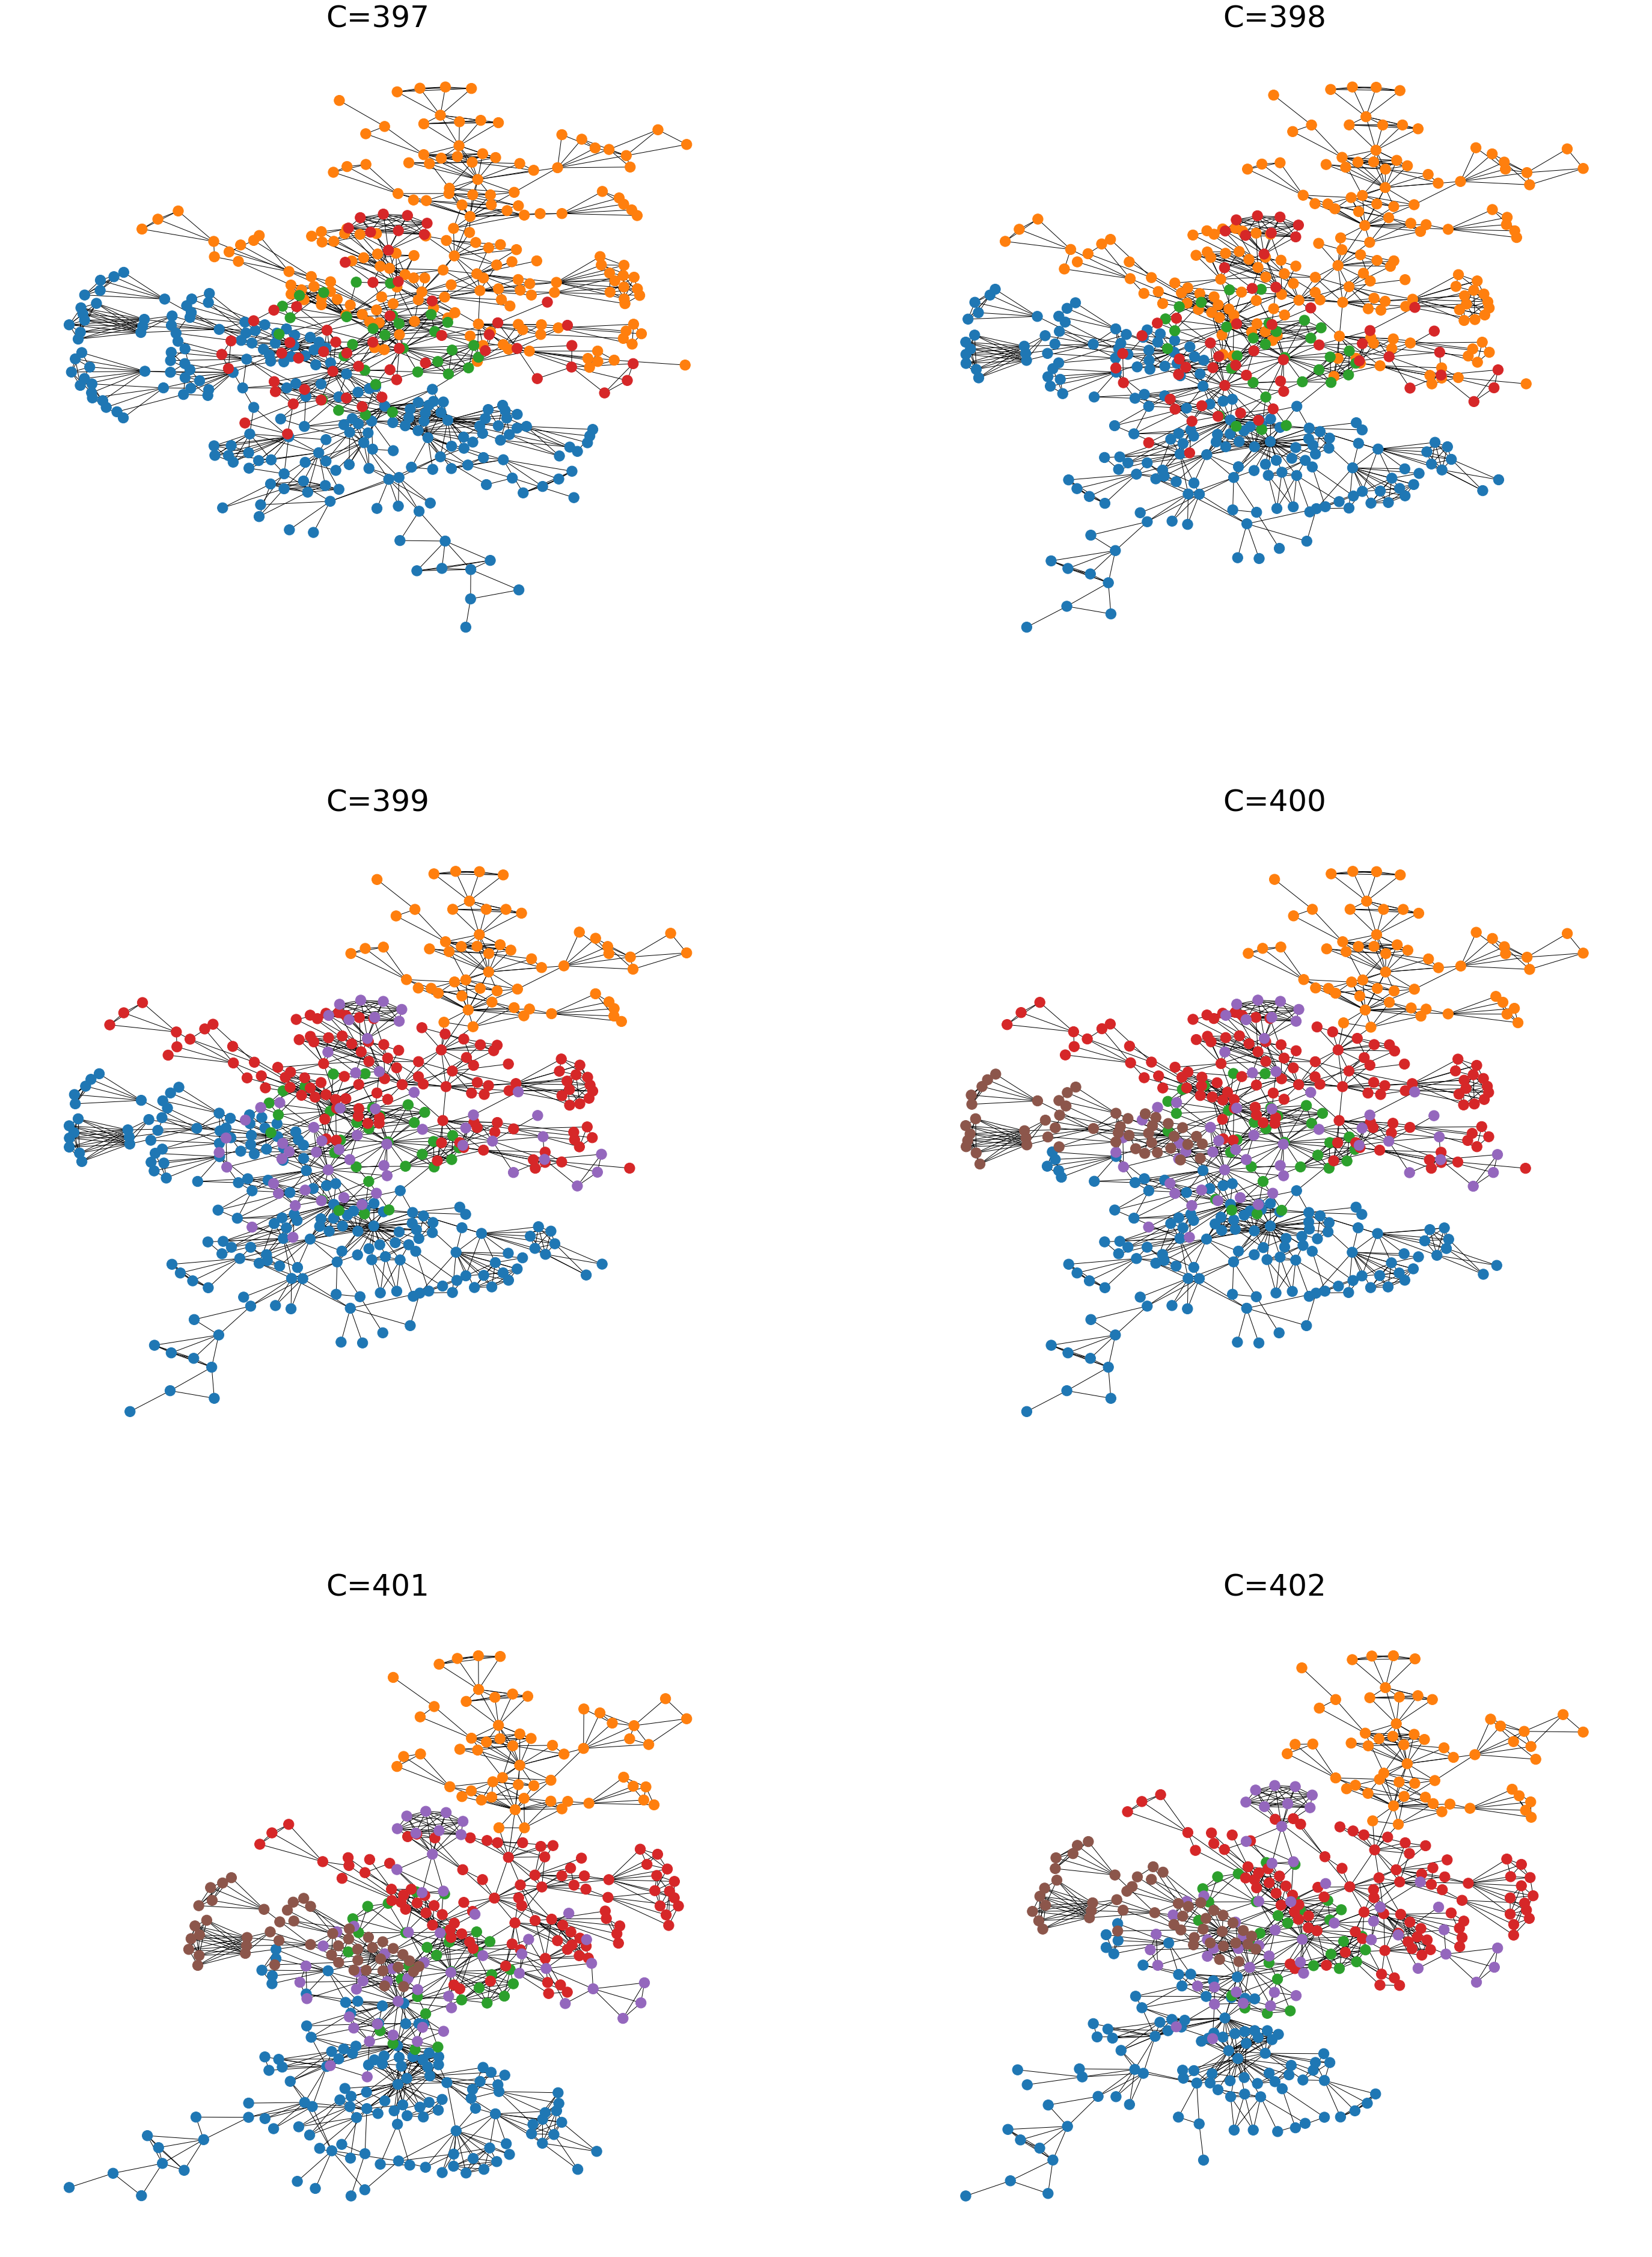

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(49,68))
for i, ax in enumerate(axes.flatten()):
    communities = community_plot(g, comm_series[i], ax=ax)
    C = len(comm_series[i])
    ax.set_title(f"C={C}", fontsize=50)
    ax.set_axis_off()
plt.savefig("../fig/communities.png")
plt.show()

## (d) Perform  (i)  a  random  attack  and  (ii)  a  targeted  attack  
on  the  network  by 
removing nodes from the network. Plot the size of the giant component against 
the fraction of nodes removed like p.17–18 in Lecture 9. 

In [13]:
def random_attack(g: nx.Graph, p):
    N = g.number_of_nodes()
    C = np.floor(N*(1-p)).astype(int)
    choices = np.random.choice(g.nodes, size=C, replace=False)
    return g.subgraph(choices)


def target_attack(g: nx.Graph, p):
    N = g.number_of_nodes()
    C = np.floor(N*(1-p)).astype(int)
    choices = [node for node, k in sorted(
        g.degree, key=lambda item:item[1])[:C]]
    return g.subgraph(choices)


def size_of_giant(g:nx.Graph):
    giant = g.subgraph(max(nx.connected_components(g), key=len))
    return giant.number_of_nodes()

In [14]:
np.random.seed(5003)
nsample = 50
ps = np.arange(0, 1, .02)
N = size_of_giant(g)
target_attack_survive = np.array(
    [*map(size_of_giant, map(part(target_attack, g), ps))])/N
random_attack_survive = np.array(
    [[*map(size_of_giant, map(part(random_attack, g), ps))] for _ in range(nsample)]).mean(axis=0)/N


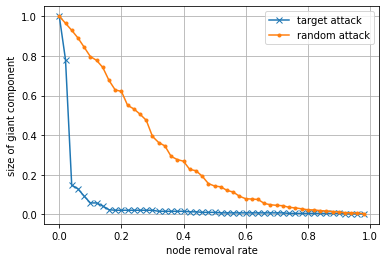

In [15]:
plt.plot(ps,target_attack_survive,marker='x',label="target attack")
plt.plot(ps,random_attack_survive,marker='.',label="random attack")
plt.xlabel("node removal rate")
plt.ylabel("size of giant component")
plt.legend()
plt.grid(True)
plt.savefig("../fig/attack.pdf")
plt.show()